In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurements.date).order_by(Measurements.date.desc()). first()

('2017-08-23',)

/var/folders/dr/nzy4jb2n46jbzbzzt42348z80000gn/T/ipykernel_55585/1848251959.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  datelist = pd.date_range(pd.datetime(2017, 8,23).strftime('%Y-%m-%d'), periods=2230).tolist()


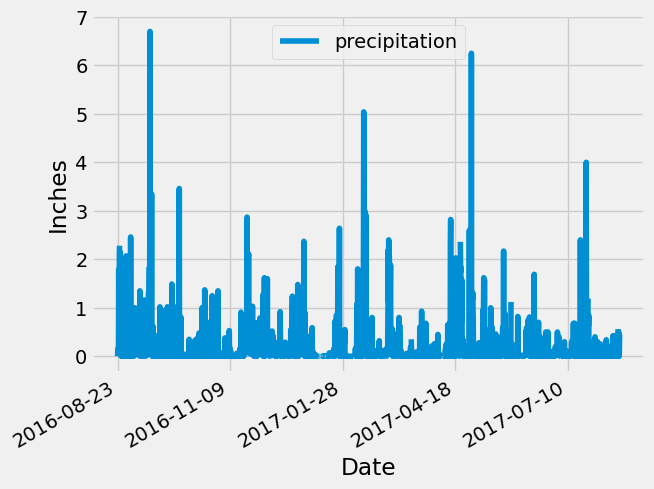

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
sel = [Measurements.date, Measurements.prcp]

query_date=dt.date(2017,8,23) - dt.timedelta(days=365)
Rain = session.query(*sel).\
    filter(Measurements.date.between(query_date, '2017-08-23')).\
    order_by(Measurements.date)\
    .all()
Rain

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
datelist = pd.date_range(pd.datetime(2017, 8,23).strftime('%Y-%m-%d'), periods=2230).tolist()
df = pd.DataFrame(Rain, columns=['date', 'precipitation'], index=pd.to_datetime(datelist))
df.set_index('date', inplace=True)
df.plot.line()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary= df.describe()
summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [171]:
# Design a query to calculate the total number of stations in the dataset
session.query(Stations.station).count()

9

In [190]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Stations.station, func.count(Measurements.station)).\
    join(Measurements, Stations.station == Measurements.station).\
    group_by(Stations.station).\
    order_by(func.count(Measurements.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [204]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
subq = session.query(Stations.station, func.count(Measurements.station)).\
    join(Measurements, Stations.station == Measurements.station).\
    group_by(Stations.station).\
    order_by(func.count(Measurements.station).desc()).first()

most_active = subq[0]

query = session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
    select_from(Measurements).\
    join(Stations, Stations.station == Measurements.station).\
    filter(Stations.station ==most_active).all()
query

[(54.0, 85.0, 71.66378066378067)]

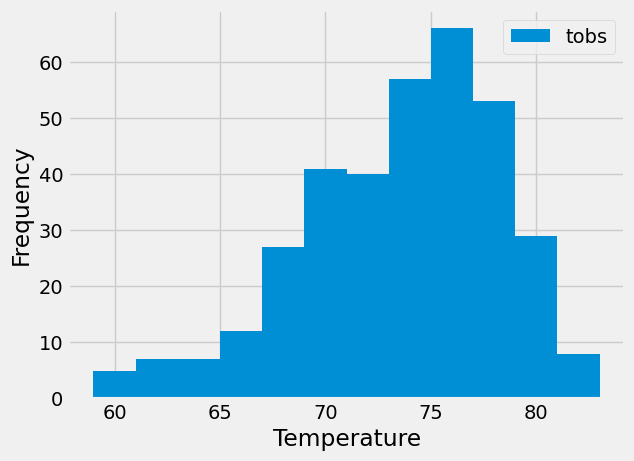

In [256]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

tobs = session.query(Measurements.tobs).\
    filter(Measurements.station == most_active).\
    filter(Measurements.date >= query_date).all()

tobs_df = pd.DataFrame(tobs, columns=['tobs'])
tobs_df.plot.hist(bins=12)

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [253]:
# Close Session
session.close()